# How to clip / reproject / resample a raster dataset

We will see how to clip, resample and/or reproject a raster dataset, obtained using `.to_xarray()` method with `rasterio` engine.

## Getting a dataset

First, we are searching for a product that will have raster data in its assets:

In [1]:
from eodag import EODataAccessGateway

dag = EODataAccessGateway()
search_criteria = {
    "productType": "S2_MSI_L2A_COG",
    "start": "2024-04-01",
    "end": "2024-04-30",
    "geom": {"lonmin": 1.306, "latmin": 42.527, "lonmax": 1.551, "latmax": 42.662},
    "cloudCover": 1,  # Cloud cover < 1
}
search_results = dag.search(**search_criteria)
product = search_results[0]
product

EOProduct(id=S2A_31TCH_20240419_0_L2A, provider=earth_search_cog)

Then, get the `xarray.Dataset` associated to `B01` asset. We specify `engine="rasterio"` (optional) in order to make sure that the datadet is opened with the appropriate engine and that [rioxarray](https://corteva.github.io/rioxarray) methods are available from it. 

In [2]:
ds = product.assets["B01"].to_xarray(engine="rasterio")
ds

<xarray.Dataset> Size: 13MB
Dimensions:      (band: 1, x: 1830, y: 1830)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 15kB 3e+05 3.001e+05 ... 4.097e+05 4.098e+05
  * y            (y) float64 15kB 4.8e+06 4.8e+06 4.8e+06 ... 4.69e+06 4.69e+06
    spatial_ref  int64 8B 0
Data variables:
    band_data    (band, y, x) float32 13MB ...
Attributes: (12/53)
    abstract:                                 The Level-2A product provides B...
    instrument:                               ['msi']
    platform:                                 sentinel-2
    platformSerialIdentifier:                 S2A
    processingLevel:                          L2
    keywords:                                 MSI,SENTINEL,SENTINEL2,S2,S2A,S...
    ...                                       ...
    s2:reflectance_conversion_factor:         0.993560600888933
    s2:sequence:                              0
    earthsearch:s3_path:                      s3://sentinel-cogs/sentinel-s2-...
    earthsearch:payload_id:                   roda-sentinel2/workflow-sentine...
    earthsearch:boa_offset_applied:           True
    processing:software:                      {'sentinel2-to-stac': '0.1.1'}

## Clip / reproject

We will clip image using previous search geometry bounds bounding box. An intersection of it and the product geometry is directly available through [EOProduct.search_intersection](https://eodag.readthedocs.io/en/stable/api_reference/eoproduct.html#eodag.api.product._product.EOProduct).

Clip dataset using [rioxarray clip_box](https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray.raster_dataset.RasterDataset.clip_box) method:

In [3]:
minx, miny, maxx, maxy = product.search_intersection.bounds
clipped_ds = ds.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy, crs="EPSG:4326")
clipped_ds

<xarray.Dataset> Size: 355kB
Dimensions:      (band: 1, x: 341, y: 257)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 3kB 3.609e+05 3.609e+05 ... 3.812e+05 3.813e+05
  * y            (y) float64 2kB 4.725e+06 4.725e+06 ... 4.709e+06 4.709e+06
    spatial_ref  int64 8B 0
Data variables:
    band_data    (band, y, x) float32 351kB ...
Attributes: (12/53)
    abstract:                                 The Level-2A product provides B...
    instrument:                               ['msi']
    platform:                                 sentinel-2
    platformSerialIdentifier:                 S2A
    processingLevel:                          L2
    keywords:                                 MSI,SENTINEL,SENTINEL2,S2,S2A,S...
    ...                                       ...
    s2:reflectance_conversion_factor:         0.993560600888933
    s2:sequence:                              0
    earthsearch:s3_path:                      s3://sentinel-cogs/sentinel-s2-...
    earthsearch:payload_id:                   roda-sentinel2/workflow-sentine...
    earthsearch:boa_offset_applied:           True
    processing:software:                      {'sentinel2-to-stac': '0.1.1'}

Resample at `0.0006°` resolution and reproject on `EPSG:4326` using [rioxarray reproject](https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray.raster_array.RasterArray.reproject) method:

In [4]:
reproj_ds = clipped_ds.rio.reproject(dst_crs="EPSG:4326", resolution=0.0006)
reproj_ds

<xarray.Dataset> Size: 406kB
Dimensions:      (x: 421, y: 238, band: 1)
Coordinates:
  * x            (x) float64 3kB 1.302 1.303 1.303 1.304 ... 1.553 1.554 1.554
  * y            (y) float64 2kB 42.67 42.66 42.66 42.66 ... 42.52 42.52 42.52
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Data variables:
    band_data    (band, y, x) float32 401kB nan nan nan nan ... nan nan nan nan
Attributes: (12/53)
    abstract:                                 The Level-2A product provides B...
    instrument:                               ['msi']
    platform:                                 sentinel-2
    platformSerialIdentifier:                 S2A
    processingLevel:                          L2
    keywords:                                 MSI,SENTINEL,SENTINEL2,S2,S2A,S...
    ...                                       ...
    s2:reflectance_conversion_factor:         0.993560600888933
    s2:sequence:                              0
    earthsearch:s3_path:                      s3://sentinel-cogs/sentinel-s2-...
    earthsearch:payload_id:                   roda-sentinel2/workflow-sentine...
    earthsearch:boa_offset_applied:           True
    processing:software:                      {'sentinel2-to-stac': '0.1.1'}

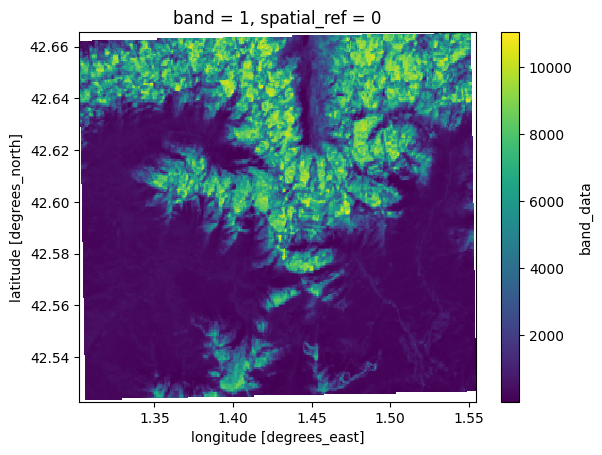

In [5]:
reproj_ds.band_data.plot()